In [109]:
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gc
import datetime
from ipywidgets import IntProgress
from matplotlib import cm
import swifter

In [42]:
gc.collect()

12231

In [43]:
server = 'analys-s'
driver = '{SQL Server}'
connstr = "DRIVER = {0};SERVER = {1};".replace(' ', '').format(driver, server)
with pyodbc.connect(connstr) as conn:
    strq = 'SELECT * \
            FROM ##BeginnersStat'
    df_begin = pd.read_sql(strq, conn)


In [44]:
server = 'analys-s'
driver = '{SQL Server}'
connstr = "DRIVER = {0};SERVER = {1};".replace(' ', '').format(driver, server)
with pyodbc.connect(connstr) as conn:
    strq = 'SELECT * \
            FROM ##CustomersStat'
    df_cust = pd.read_sql(strq, conn)

In [45]:
df_begin = df_begin.rename(columns = {'Orderds':'Orders'})
df_begin

,CURDISCOUNTCARDTYPE,CURDISCOUNTCARDID,Orders,MeanCheck
0,08,30275757,1,3539.399902
1,08,30277553,1,399.000000
2,08,30278001,1,389.350006
3,08,30285573,1,2503.000000
4,08,30319068,1,298.000000
...,...,...,...,...
1507661,04,15217717,1,5124.500000
1507662,04,15367261,1,848.500000
1507663,04,14830736,2,803.500000
1507664,04,15473358,1,2661.750000


In [46]:
df_cust = df_cust.rename(columns = {'Orderds':'Orders'})
df_cust

,CURDISCOUNTCARDTYPE,CURDISCOUNTCARDID,Orders,MeanCheck
0,05,10002688,2,718.465000
1,05,10254420,1,4399.500000
2,05,10449951,2,2556.000000
3,05,10468861,4,933.600006
4,05,10509415,2,2621.700104
...,...,...,...,...
11793651,04,07531052,6,642.466667
11793652,05,09953502,3,3762.000000
11793653,04,12284407,1,857.000000
11793654,08,27976644,2,953.900009


In [47]:
filter_df = list(df_begin.Orders.quantile([0.99]))
df_begin = df_begin.query(f"Orders <= {filter_df[0]}")

filter_df = list(df_begin.MeanCheck.quantile([0.99]))
df_begin = df_begin.query(f"MeanCheck <= {filter_df[0]}")




In [48]:
filter_df = list(df_cust.Orders.quantile([0.99]))
df_cust = df_cust.query(f"Orders < {filter_df[0]}")

filter_df = list(df_cust.MeanCheck.quantile([0.99]))
df_cust = df_cust.query(f"MeanCheck < {filter_df[0]}")

In [49]:
def GetCMap(curr, max_):
    cmap = cm.gnuplot(range(256))
    return cmap[int((curr / max_) * 255)]

In [50]:
def PrintHistOrders(df, density = False,
               percentiles = [.25, .50] + np.arange(.7, .99, 0.02).tolist(),
               yticks = 0.001
              ):

        strp = ''
        for p in percentiles:
            strp += str(round(p, 2)) + '; '
        n = df.shape[0]
        fig, ax = plt.subplots(figsize = (20, 10))
        n = len(percentiles)
        
        max_x = df.Orders.max()
        bins = np.arange(0, max_x + 1, 1)
        df.hist( bins = bins, ax = ax, density = density)
        
        lines = list(df.Orders.quantile(percentiles))
        ax.set_xticks(np.arange(0, max_x, 1))
        ax.set_xlabel("Количество покупок")
        ax.set_ylabel("Уникальные покупатели")
        if(density):
             ax.set_yticks(np.arange(min(ax.get_ylim()), max(ax.get_ylim()), yticks))
        k = 0
        np.random.seed(115)
        for p in percentiles:
            ax.axvline(lines[k], label = str(p) + f' : {lines[k]} покупок', c= GetCMap(lines[k], lines[-1]), linewidth = 4)
            k += 1
        ax.set_title("Частоты покупателей в зависимости от количества покупок\nПерсентили " + strp)
        ax.legend()
        
        time_str = str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').split('.')[0]
        if(density):
            plt.savefig('Orders_Hist_Density_{0}.png'.format(time_str))
        else:
            plt.savefig('Orders_Hist_{0}.png'.format(time_str))

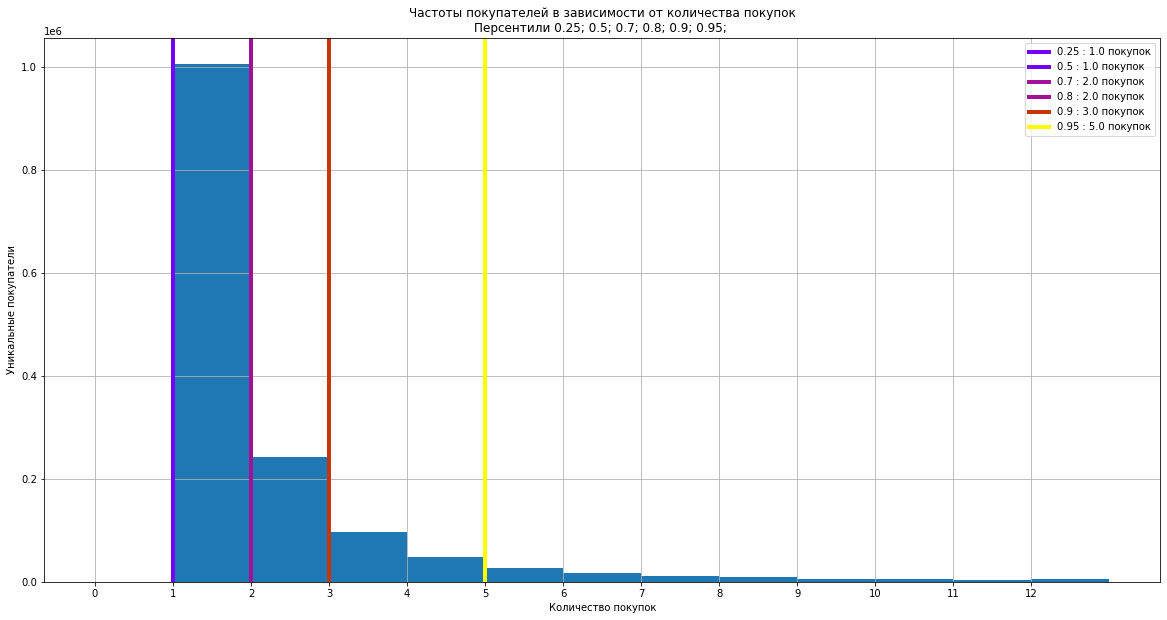

In [51]:
PrintHistOrders(pd.DataFrame(df_begin.Orders), percentiles = [.25, .50, .7, .8, .9, .95])

Топ сегмент новичков - 3+ покупок


Средний сегмент - 2 покупки


Нижний сегмент - 1 покупка

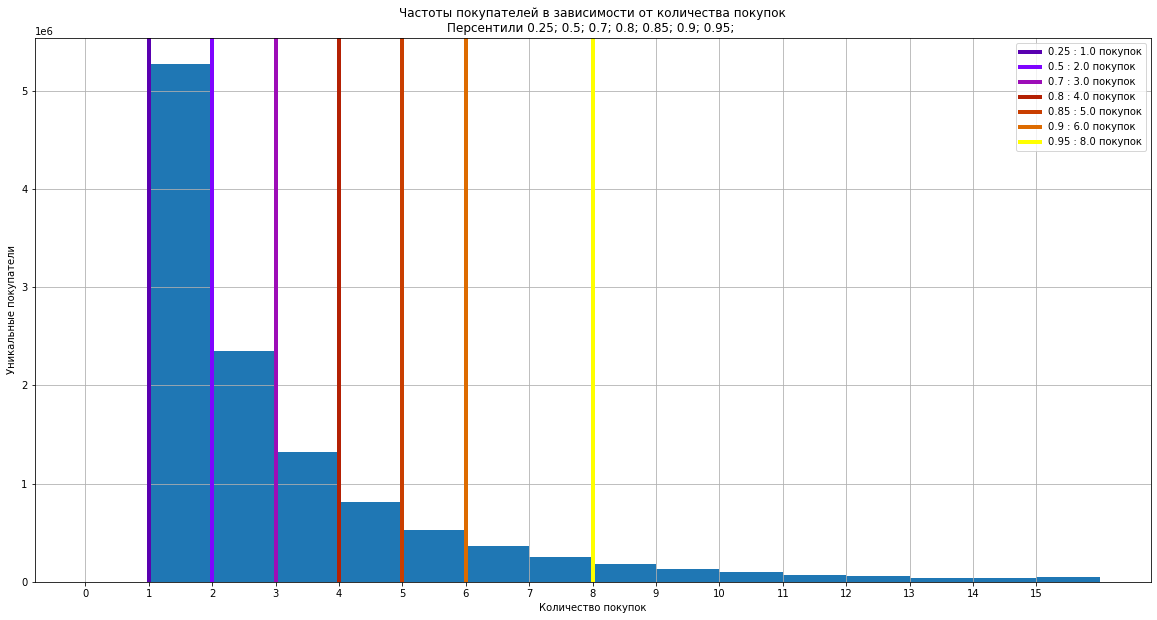

In [102]:
PrintHistOrders(pd.DataFrame(df_cust.Orders),  percentiles = [.25, .50, .7, .8, .85, .9, .95])

Топ сегмент за полтора года - 5+ покупок


Хорошие - 3+ покупок


Средний сегмент - 2 покупки


Нижний сегмент - 1 покупка

In [53]:
def PrintHistMeanCheck(df, bins = 10, density = False, xticks = 100,
               percentiles = [.25, .50] + np.arange(.7, .99, 0.02).tolist(),
               yticks = 0.001
              ):

        strp = ''
        for p in percentiles:
            strp += str(round(p, 2)) + '; '
        n = df.shape[0]
        fig, ax = plt.subplots(figsize = (20, 10))
        n = len(percentiles)
        
         
        df.hist( bins = bins, ax = ax, density = density)
        max_x = df.MeanCheck.max()
        lines = list(df.MeanCheck.quantile(percentiles))
        ax.set_xticks(np.arange(0, max_x, xticks))
        ax.set_xlabel("Средний чек")
        ax.set_ylabel("Уникальные покупатели")
        if(density):
             ax.set_yticks(np.arange(min(ax.get_ylim()), max(ax.get_ylim()), yticks))
        k = 0
        np.random.seed(115)
        for p in percentiles:
            ax.axvline(lines[k], label = str(p) + f' : {lines[k]} покупок', c= GetCMap(lines[k], lines[-1]), linewidth = 4)
            k += 1
        ax.set_title("Частоты покупателей в зависимости от среднего чека\nПерсентили " + strp)
        ax.legend()
        
        time_str = str(datetime.datetime.now()).replace(' ', '_').replace(':', '_').split('.')[0]
        if(density):
            plt.savefig('MeanCHeck_Hist_Density_{0}.png'.format(time_str))
        else:
            plt.savefig('MeanCHeck_Hist_{0}.png'.format(time_str))

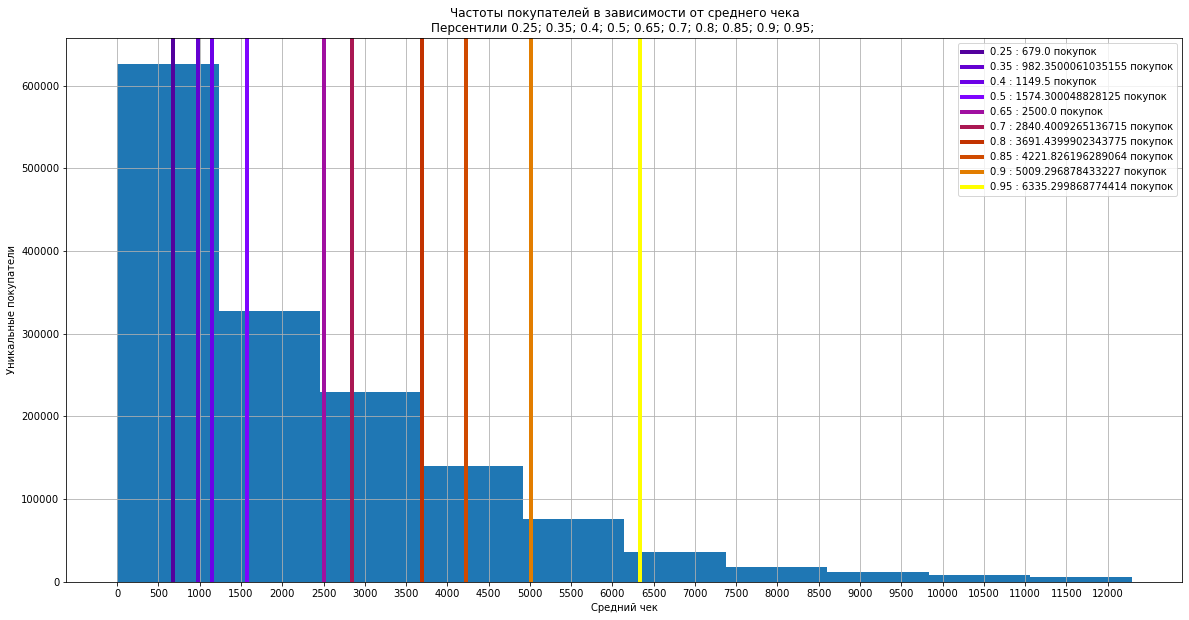

In [107]:
PrintHistMeanCheck(pd.DataFrame(df_begin.MeanCheck), xticks = 500, percentiles = [.25, .35, .4, .50, .65, .7, .8, .85, .9, .95])

Топ сегмент новичков - средний чек 4 200р и больше (Процентиль 85%)


Хороший сегмент - средний чек 2 500 р и больше (Процентиль 65%)


Средний сегмент - средний чек 1 200 и больше (Процентиль 40%)

Нижний сегмент - до  1 200

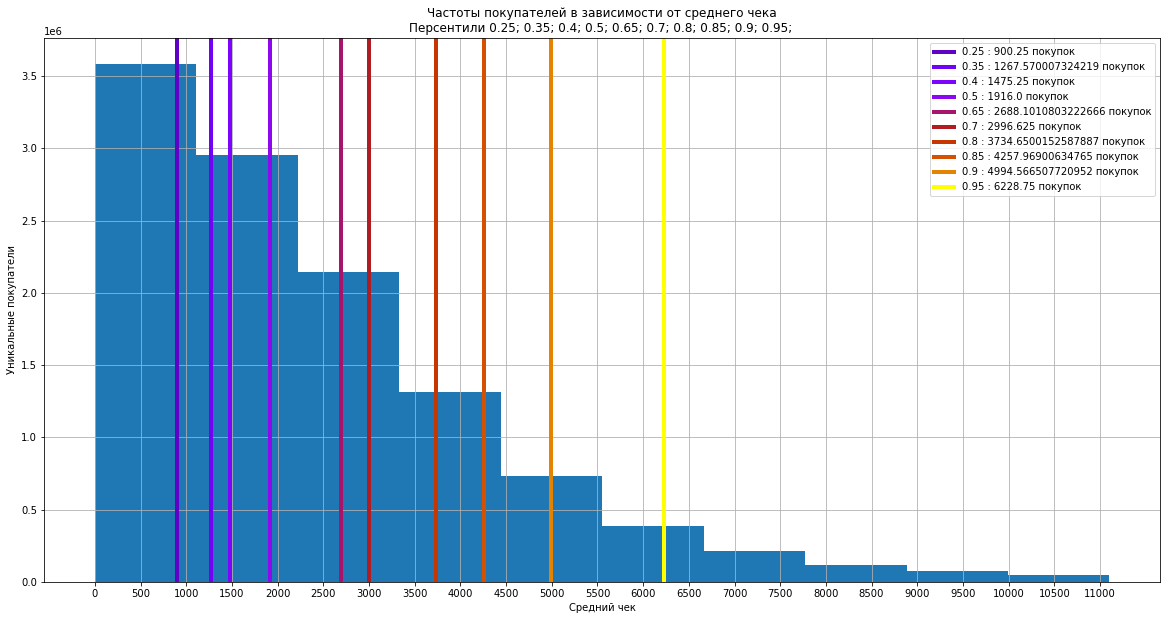

In [108]:
PrintHistMeanCheck(pd.DataFrame(df_cust.MeanCheck), xticks = 500, percentiles = [.25, .35, .4, .50, .65, .7, .8, .85, .9, .95])

Топ сегмент за полтора года - средний чек 4 200р и больше (Процентиль 85%)


Хороший сегмент - средний чек 2 500 р и больше (Процентиль 65%)


Средний сегмент - средний чек 1 200 и больше (Процентиль 40%)

Нижний сегмент - до  1 200

In [56]:
gc.collect()

24821

# Создание базы

In [111]:
def GetOrderSegBeginners(x):
    if(x >= 3):
        return 'TOP'
    elif(x == 2):
        return 'MIDDLE'
    else:
        return 'LOW'
    
    
def GetOrderSeg(x):
    if(x >= 5):
        return 'TOP'
    elif(x >= 3):
        return 'GOOD'
    elif(x == 2):
        return 'MIDDLE'
    else:
        return 'LOW'
    
    
    
 
# Топ сегмент новичков - средний чек 4 200р и больше (Процентиль 85%)
# Хороший сегмент - средний чек 2 500 р и больше (Процентиль 65%)
# Средний сегмент - средний чек 1 200 и больше (Процентиль 40%)
# Нижний сегмент - до  1 200

def GetMeanCheckSeg(x):
    if(x >= 4200):
        return 'TOP'
    elif(x >= 2500):
        return 'GOOD'
    elif(x >= 1200):
        return 'MIDDLE'
    else:
        return 'LOW'
    


In [112]:
df_cust['Beginner'] = 0
df_cust['OrderSeg'] = df_cust.swifter.apply(lambda x: GetOrderSeg(x.Orders), axis = 1)
df_cust['MeanCheckSeg'] = df_cust.swifter.apply(lambda x: GetMeanCheckSeg(x.MeanCheck), axis = 1)


Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

<bound method NDFrame.describe of          CURDISCOUNTCARDTYPE CURDISCOUNTCARDID  Orders    MeanCheck  Beginner  \
0                         05          10002688       2   718.465000         0   
1                         05          10254420       1  4399.500000         0   
2                         05          10449951       2  2556.000000         0   
3                         05          10468861       4   933.600006         0   
4                         05          10509415       2  2621.700104         0   
...                      ...               ...     ...          ...       ...   
11793651                  04          07531052       6   642.466667         0   
11793652                  05          09953502       3  3762.000000         0   
11793653                  04          12284407       1   857.000000         0   
11793654                  08          27976644       2   953.900009         0   
11793655                  04          05587021      13  1285.958455        

In [114]:
df_cust.describe()

,Orders,MeanCheck,Beginner
count,1.155739e+07,1.155739e+07,11557389.0
mean,2.649029e+00,2.385571e+03,0.0
std,2.485425e+00,1.929700e+03,0.0
min,1.000000e+00,0.000000e+00,0.0
25%,1.000000e+00,9.002500e+02,0.0
50%,2.000000e+00,1.916000e+03,0.0
75%,3.000000e+00,3.325000e+03,0.0
max,1.600000e+01,1.110310e+04,0.0


In [115]:
df_cust[['OrderSeg','MeanCheckSeg']].describe()

,OrderSeg,MeanCheckSeg
count,11557389,11557389
unique,4,4
top,LOW,LOW
freq,5271391,3855951


In [113]:
df_begin['Beginner'] = 1
df_begin['OrderSeg'] = df_cust.swifter.apply(lambda x: GetOrderSegBeginners(x.Orders), axis = 1)
df_begin['MeanCheckSeg'] = df_cust.swifter.apply(lambda x: GetMeanCheckSeg(x.MeanCheck), axis = 1)
df_begin.describe

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/8 [00:00<?, ?it/s]

<bound method NDFrame.describe of         CURDISCOUNTCARDTYPE CURDISCOUNTCARDID  Orders    MeanCheck  Beginner  \
0                        08          30275757       1  3539.399902         1   
1                        08          30277553       1   399.000000         1   
2                        08          30278001       1   389.350006         1   
3                        08          30285573       1  2503.000000         1   
4                        08          30319068       1   298.000000         1   
...                     ...               ...     ...          ...       ...   
1507661                  04          15217717       1  5124.500000         1   
1507662                  04          15367261       1   848.500000         1   
1507663                  04          14830736       2   803.500000         1   
1507664                  04          15473358       1  2661.750000         1   
1507665                  04          15550459       1   299.000000         1   

     

In [116]:
df_begin.describe()

,Orders,MeanCheck,Beginner
count,1.478554e+06,1.478554e+06,1478554.0
mean,1.742368e+00,2.241232e+03,1.0
std,1.605588e+00,2.060765e+03,0.0
min,1.000000e+00,0.000000e+00,1.0
25%,1.000000e+00,6.790000e+02,1.0
50%,1.000000e+00,1.574300e+03,1.0
75%,2.000000e+00,3.209200e+03,1.0
max,1.300000e+01,1.229240e+04,1.0


In [117]:
df_begin[['OrderSeg','MeanCheckSeg']].describe()

,OrderSeg,MeanCheckSeg
count,1448884,1448884
unique,3,4
top,LOW,LOW
freq,660810,482300


In [118]:
df_merge = pd.concat([df_begin, df_cust])


In [119]:
df_merge.describe()

,Orders,MeanCheck,Beginner
count,1.303594e+07,1.303594e+07,1.303594e+07
mean,2.546194e+00,2.369200e+03,1.134213e-01
std,2.419038e+00,1.945548e+03,3.171071e-01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,8.697000e+02,0.000000e+00
50%,2.000000e+00,1.880983e+03,0.000000e+00
75%,3.000000e+00,3.313750e+03,0.000000e+00
max,1.600000e+01,1.229240e+04,1.000000e+00


In [120]:
df_merge[['OrderSeg','MeanCheckSeg']].describe()

,OrderSeg,MeanCheckSeg
count,13006273,13006273
unique,4,4
top,LOW,LOW
freq,5932201,4338251


In [121]:
df_merge.to_csv('NewSegCustomers.csv', index = False)